# Georgia Service Cards
This file gets information on soldiers that enlisted in Georgia and died serving in World War one and looks at the information we get about detah place and date.  
Author: Ben Branchflower  
Created: 6 Sep 2018

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
from matplotlib import pyplot as plt
import requests
import seaborn

%matplotlib inline

## Getting the data
Scraping the source code of the page with the data on the soldiers

In [2]:
with requests.Session() as s:
    # letting them know who I am and assuring I get the same response type every time
    s.headers.update({'User-Agent':'benbranchflower@gmail.com', 'Accept':'tex/html'})
    response = s.get('https://www.worldwar1centennial.org/index.php/georgia-memorial-database.html')
    if response.status_code != 200:
        raise ValueError("Bad response code")

There is only one table in the response text so I can just loop over the rows and get data on each of the individuals 

In [3]:
soup = BeautifulSoup(response.text, 'html5lib')
# this next line makes the table a list of list to be fed into the pandas Dataframe instantiation
df = pd.DataFrame([[d.text for d in row.find_all('td')][:-1] for row in soup.find_all('tr')])
# Moving the first row to be the headers and the dropping them
df.columns = df.iloc[0,:]
df = df.reindex(df.index.drop(0)) 
# taking a peek to see if things are working properly
df.head()

,Rank,Name,County,City,Death date,Eth.,Citation,Disposition,Photo
1,PVT,"Aaron, Charlie Floyd",Newton,Starrsville,9-Oct-1918,W,"MB 132, Newton, GDC, Knight",infection - France,yes
2,CPL,"Abercrombie, Lewis Felton",Fulton,Atlanta,8-Jun-1918,W,GDC,wound,
3,PVT,"Abner, Cecil",Polk,Rockmart,23-May-1919,W,"MB 136, GDC, Knight",pneumonia - overseas,yes
4,PVT,"Abner, Lewis Felton",Polk,,23-Aug-1918,,GDC,pneumonia,
5,PVT,"Adair, Chester Price",Clarke,Athens,14-Sep-1918,W,"MB 051, Knight",infection,yes


# Cleaning the data
The data is pretty messy so I will clean up some column names and then make some new columns from what we have so the columns are a little more precise.

In [4]:
df.rename({'Eth.':'Ethnicity'}, axis='columns', inplace=True)
df['Death Place'] = df.Disposition.str.extract(r'-\s([A-Z].+)\s?$')
df['State'] = 'Georgia'
df['Surname'] = df.Name.str.extract(r'^(.+),') # separating the names into different columns
df['Given Names'] = df.Name.str.extract(r', (.+)$')
df['Death Day'] = df['Death date'].str.extract(r'^(\d{1,2})-') # splitting the death date into parts
df['Death Month'] = df['Death date'].str.extract(r'-(\w+)-')
df['Death Year'] = df['Death date'].str.extract(r'-(\d{4})$')
df['Death Month Year'] = df['Death Month'].str.cat(df['Death Year'], sep=' ')
df['Death date'] = df['Death date'].str.replace(r'-', ' ') # cleaning up the look of the death date
df['Cause of Death'] = df['Disposition'].str.extract(r'(.+?)(?:\s?-|$)')
df.head()

,Rank,Name,County,City,Death date,Ethnicity,Citation,Disposition,Photo,Death Place,State,Surname,Given Names,Death Day,Death Month,Death Year,Death Month Year,Cause of Death
1,PVT,"Aaron, Charlie Floyd",Newton,Starrsville,9 Oct 1918,W,"MB 132, Newton, GDC, Knight",infection - France,yes,France,Georgia,Aaron,Charlie Floyd,9,Oct,1918,Oct 1918,infection
2,CPL,"Abercrombie, Lewis Felton",Fulton,Atlanta,8 Jun 1918,W,GDC,wound,,NaN,Georgia,Abercrombie,Lewis Felton,8,Jun,1918,Jun 1918,wound
3,PVT,"Abner, Cecil",Polk,Rockmart,23 May 1919,W,"MB 136, GDC, Knight",pneumonia - overseas,yes,NaN,Georgia,Abner,Cecil,23,May,1919,May 1919,pneumonia
4,PVT,"Abner, Lewis Felton",Polk,,23 Aug 1918,,GDC,pneumonia,,NaN,Georgia,Abner,Lewis Felton,23,Aug,1918,Aug 1918,pneumonia
5,PVT,"Adair, Chester Price",Clarke,Athens,14 Sep 1918,W,"MB 051, Knight",infection,yes,NaN,Georgia,Adair,Chester Price,14,Sep,1918,Sep 1918,infection


Now that what we have is a little cleaner, let's move on to getting some counts of the occurences of different counties, death place, surnames and death month.

In [5]:
surn_occurs = dict(df['Surname'].value_counts()) # getting a dictionary for numbers of appearances
df['surn_occur'] = [surn_occurs.get(x, 0) for x in df['Surname']] # filling the column with the corresponding data
dp_occurs = dict(df['Death Place'].value_counts()) # lather
df['dplace_occur'] = [dp_occurs.get(x, 0) for x in df['Death Place']]
dm_occurs = dict(df['Death Month Year'].value_counts()) # rinse
df['dmonth_occur'] = [dm_occurs.get(x, 0) for x in df['Death Month Year']]
dp_co_occurs = df['Death Place'].str.cat(df['County']).value_counts(dropna=True) # repeat
df['county_dplace_occur'] = [dp_co_occurs.get(x, 0) for x in df['Death Place'].str.cat(df['County']).fillna('')]
df.head()

,Rank,Name,County,City,Death date,Ethnicity,Citation,Disposition,Photo,Death Place,...,Given Names,Death Day,Death Month,Death Year,Death Month Year,Cause of Death,surn_occur,dplace_occur,dmonth_occur,county_dplace_occur
1,PVT,"Aaron, Charlie Floyd",Newton,Starrsville,9 Oct 1918,W,"MB 132, Newton, GDC, Knight",infection - France,yes,France,...,Charlie Floyd,9,Oct,1918,Oct 1918,infection,1,187,1136,4
2,CPL,"Abercrombie, Lewis Felton",Fulton,Atlanta,8 Jun 1918,W,GDC,wound,,NaN,...,Lewis Felton,8,Jun,1918,Jun 1918,wound,1,0,93,0
3,PVT,"Abner, Cecil",Polk,Rockmart,23 May 1919,W,"MB 136, GDC, Knight",pneumonia - overseas,yes,NaN,...,Cecil,23,May,1919,May 1919,pneumonia,2,0,21,0
4,PVT,"Abner, Lewis Felton",Polk,,23 Aug 1918,,GDC,pneumonia,,NaN,...,Lewis Felton,23,Aug,1918,Aug 1918,pneumonia,2,0,105,0
5,PVT,"Adair, Chester Price",Clarke,Athens,14 Sep 1918,W,"MB 051, Knight",infection,yes,NaN,...,Chester Price,14,Sep,1918,Sep 1918,infection,2,0,297,0


# Visualisation  
Now, let's look at what this data can show us with some bar plots initially to gett a feel for how and when the soldiers died

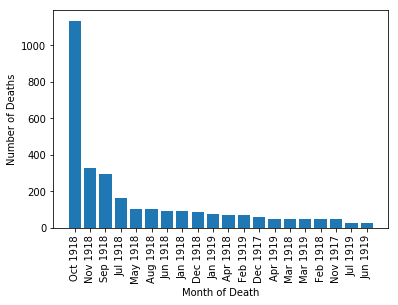

In [6]:
def make_barplot(x, y, xlab, ylab, xrotation='vertical'):
    """This makes a quick barplot with matplotlib"""
    plt.xticks(rotation=xrotation)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.bar(x, y)

# the number of date makes it hard to look at so lets just look at 20 of the months
make_barplot(df['Death Month Year'].value_counts()[:20].index,
            df['Death Month Year'].value_counts()[:20], xlab='Month of Death',
            ylab='Number of Deaths')

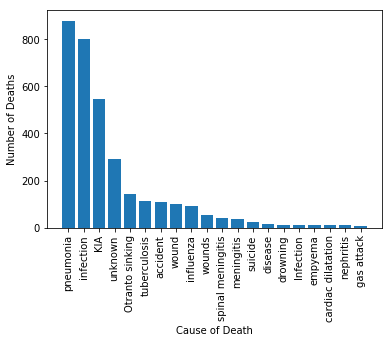

In [7]:
make_barplot(df['Cause of Death'].value_counts()[:20].index,
            df['Cause of Death'].value_counts()[:20], xlab='Cause of Death',
            ylab='Number of Deaths', xrotation='vertical')

So it looks like the biggest times of death were September and November of 1918 from pneumonia and infection. Let's look at how that looks if we separate the data by location as well. We should be able to get a feel for where some of the battles were if a lot casualties occured in one place at a given time.

In [8]:
sns.set()
# creating a summay table of deaths by month and death place
def make_heatmap(df, index, columns, values):
    """This finction makes a heatmap by counts of categorical variables"""
    temp = pd.pivot_table(df, index=index, columns=columns,
                              values=values, dropna=True, fill_value=0)
    temp.dropna(how='all', inplace=True)
    temp = temp[temp.max(axis=1) > 3]
    temp = temp.transpose()[temp.transpose().max(axis=1) > 1]
    seaborn.heatmap(temp)
make_heatmap(df, index='Death Month Year', columns='Death Place', values='county_dplace_occur')

NameError: name 'sns' is not defined

Let's do a similar thing with places the soldiers enlisted and where the soldiers died to look at how the deaths change by places and month of death.

In [ ]:
make_heatmap(df, index='County', columns='Death Place', values='county_dplace_occur')

We can look at how people died in different locations as well

In [ ]:
make_heatmap(df, index='Cause of Death', columns='Death Place', values='county_dplace_occur')

So for this it looks like while many people died of illness like pneumonie or infections, they were not the primary cause of death in France.